# Example Notebook

This notebook is designed demonstrate a number of goals:

  - The notebook is part of the automated analytical pipeline, as it is run programmatically by the build system, as in the dodo.py file.
  - It is tracked by version control via Git. To avoid large files and the problems associated with non-text files, the notebook is stripped of its output. 
  - In order to avoid re-running the notebook every time it changes (it changes often, even by the act of opening it) and to only rerun it if meaningful changes have been made, the build system only looks for changes in the plaintext version of the notebook. That is, the notebook is converted to a Python script via [nbconvert](https://nbconvert.readthedocs.io/en/latest/), which is often packaged with Jupyter.
  Then, DoIt looks for changes to the Python version. If it detects a difference, then the notebook is re-run. (Note, that you could also convert to a Markdown file with 
  [JupyText](https://github.com/mwouts/jupytext). However, this package is often not packaged with Jupyter.)
  - Since we want to use Jupyter Notebooks for exploratory reports, we want to keep fully-computed versions of the notebook (with the output intact). However, earlier I said that I strip the notebook of its output before committing to version control. Well, to keep the output, every time PyDoit runs the notebook, it outputs an HTML version of the freshly run notebook and saves that HTML report in the `output` directory. That way, you will be able to view the finished report at any time without having to open Jupyter.

In [1]:
import config
from pathlib import Path
OUTPUT_DIR = Path(config.OUTPUT_DIR)
DATA_DIR = Path(config.DATA_DIR)
WRDS_USERNAME = config.WRDS_USERNAME

START_DATE = config.START_DATE
END_DATE = config.END_DATE

In [2]:
from datetime import datetime
from dateutil.relativedelta import relativedelta
from pathlib import Path

import numpy as np
import pandas as pd
import wrds

import config

In [3]:
db = wrds.Connection(wrds_username=WRDS_USERNAME)

WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


In [4]:
db.list_tables(library = 'bank_all')

['wrds_bank_reg_vars',
 'wrds_call_rcfa_1',
 'wrds_call_rcfd_1',
 'wrds_call_rcfd_2',
 'wrds_call_rcfn_1',
 'wrds_call_rcfw_1',
 'wrds_call_rcoa_1',
 'wrds_call_rcon_1',
 'wrds_call_rcon_2',
 'wrds_call_rcow_1',
 'wrds_call_riad_1',
 'wrds_call_te_1',
 'wrds_holding_bhck_1',
 'wrds_holding_bhck_2',
 'wrds_holding_other_1']

#### not working on my computer……

In [5]:
query = f"""
    SELECT 
        
        rcfd_1.rssd9001, rcfd_1.rssd9050, rcfd_1.rssd9999,
        rcfd_1.rcfd0010,rcfd_1.rcfd1773,rcfd_1.rcfdg301,rcfd_1.rcfdg303,
        rcfd_1.rcfdg305,rcfd_1.rcfdg307,rcfd_1.rcfdg309,rcfd_1.rcfdg311,
        rcfd_1.rcfdg313,rcfd_1.rcfdg315,rcfd_1.rcfdg317,rcfd_1.rcfdg319,
        rcfd_1.rcfdg321,rcfd_1.rcfdg323,rcfd_1.rcfdk143,rcfd_1.rcfdk145,
        rcfd_1.rcfdk147,rcfd_1.rcfdk149, rcfd_1.rcfdk151,rcfd_1.rcfdk153,
        rcfd_1.rcfdk155,rcfd_1.rcfdk157, rcfd_1.rcfdc988,rcfd_1.rcfdc027,
        rcfd_1.RCFD1738,rcfd_1.RCFD1741, rcfd_1.RCFD1743,rcfd_1.RCFD1746,
        rcfd_1.rcfdf158,rcfd_1.rcfdf159, rcfd_1.rcfd5367,rcfd_1.rcfd5368,
        rcfd_1.rcfdf160,rcfd_1.rcfdf161, rcfd_1.rcfd1590,rcfd_1.rcfd1763,
        rcfd_1.rcfd1764,rcfd_1.rcfdb538, rcfd_1.rcfdb539,rcfd_1.rcfdk137,
        rcfd_1.rcfdk137,rcfd_1.rcfdk207,

        rcfd_2.rcfd1771,rcfd_2.rcfd0213,rcfd_2.rcfd1287,rcfd_2.rcfd2122,
        rcfd_2.rcfd1420,rcfd_2.rcfd1797,rcfd_2.rcfd1460,rcfd_2.rcfdb989,

        rcon_1.rconj454,rcon_1.rconb987

    FROM bank_all.wrds_call_rcfd_1 AS rcfd_1
    LEFT JOIN 
        bank_all.wrds_call_rcfd_2 as rcfd_2
    ON 
        rcfd_1.rssd9050 = rcfd_2.rssd9050 AND
        rcfd_1.rssd9001 = rcfd_2.rssd9001 AND
        rcfd_1.rssd9999 <= rcfd_2.rssd9999 AND
        rcfd_2.rssd9999 <= rcfd_1.rssd9999
        
    LEFT JOIN 
        bank_all.wrds_call_rcon_1 as rcon_1
    ON 
        rcfd_1.rssd9050 = rcon_1.rssd9050 AND
        rcfd_1.rssd9001 = rcon_1.rssd9001 AND
        rcfd_1.rssd9999 <= rcon_1.rssd9999 AND
        rcfd_2.rssd9999 <= rcon_1.rssd9999
    WHERE 
        rcfd_1.rssd9999  = '{END_DATE}' 
    """

### SQL to acquire data from WRDS

In [5]:
rcon_1_query = f"""
    SELECT 
        rcon_1.rssd9999, rcon_1.rssd9001,
        rcon_1.RCON0071, rcon_1.RCON1773, rcon_1.RCONHT55,
        rcon_1.RCONHT57, rcon_1.RCONG309, rcon_1.RCONG311,
        rcon_1.RCONG313, rcon_1.RCONG315, rcon_1.RCONG317,
        rcon_1.RCONG319, rcon_1.RCONG321, rcon_1.RCONG323,
        rcon_1.RCONK143, rcon_1.RCONK145, rcon_1.RCONK147,
        rcon_1.RCONK149, rcon_1.RCONK151, rcon_1.RCONK153,
        rcon_1.RCONK155, rcon_1.RCONK157, rcon_1.RCONC988,
        rcon_1.RCONC027, rcon_1.RCONHT59, rcon_1.RCONHT61,
        rcon_1.RCON1743, rcon_1.RCON1746, rcon_1.RCONF158,
        rcon_1.RCONF159, rcon_1.RCON5367, rcon_1.RCON5368,
        rcon_1.RCONF160, rcon_1.RCONF161, rcon_1.RCON1590,
        rcon_1.RCON1766, rcon_1.RCONB538, rcon_1.RCONK137,
        rcon_1.RCONK207, rcon_1.rconj454, rcon_1.RCONJ454,
       
        rcon_1.RCONB987, rcon_1.RCONJ451,

        rcon_1.rconmt91, rcon_1.rconmt87, rcon_1.rconhk14, rcon_1.rconhk15,
        rcon_1.rconb993, rcon_1.rcon3230

   
    FROM 
        bank_all.wrds_call_rcon_1 AS rcon_1
    
    
    WHERE 
        rcon_1.rssd9999  = '{END_DATE}' 
    """
rcon_2_query = f"""
    SELECT 
        rcon_2.rssd9001,rcon_2.rcon0081, rcon_2.rcon1771, rcon_2.rcon0213, 
        rcon_2.rcon1287, rcon_2.rcon1738, rcon_2.rcon1741, rcon_2.rcon2122,
        rcon_2.rcon1420, rcon_2.rcon1797, rcon_2.rcon1460, rcon_2.rconb539,
        rcon_2.rconj464, rcon_2.rconb989,

        rcon_2.rcon2200, rcon_2.rconhk05, rcon_2.rconj474, rcon_2.rconb995,
        rcon_2.rconk222, rcon_2.rcon2948, rcon_2.rcon2930, rcon_2.rcong105,
        rcon_2.rcon3838, rcon_2.rcon3632, rcon_2.rcon2170


    FROM 
        bank_all.wrds_call_rcon_2 AS rcon_2
    
    
    WHERE 
        rcon_2.rssd9999  = '{END_DATE}' 
    """

In [6]:
rcfd_1_query = f"""
    SELECT 
        rcfd_1.rssd9001, rcfd_1.rssd9999,
        rcfd_1.rcfd0010,rcfd_1.rcfd1773,rcfd_1.rcfdg301,rcfd_1.rcfdg303,
        rcfd_1.rcfdg305,rcfd_1.rcfdg307,rcfd_1.rcfdg309,rcfd_1.rcfdg311,
        rcfd_1.rcfdg313,rcfd_1.rcfdg315,rcfd_1.rcfdg317,rcfd_1.rcfdg319,
        rcfd_1.rcfdg321,rcfd_1.rcfdg323,rcfd_1.rcfdk143,rcfd_1.rcfdk145,
        rcfd_1.rcfdk147,rcfd_1.rcfdk149, rcfd_1.rcfdk151,rcfd_1.rcfdk153,
        rcfd_1.rcfdk155,rcfd_1.rcfdk157, rcfd_1.rcfdc988,rcfd_1.rcfdc027,
        rcfd_1.RCFD1738,rcfd_1.RCFD1741, rcfd_1.RCFD1743,rcfd_1.RCFD1746,
        rcfd_1.rcfdf158,rcfd_1.rcfdf159, rcfd_1.rcfd5367,rcfd_1.rcfd5368,
        rcfd_1.rcfdf160,rcfd_1.rcfdf161, rcfd_1.rcfd1590,rcfd_1.rcfd1763,
        rcfd_1.rcfd1764,rcfd_1.rcfdb538, rcfd_1.rcfdb539,rcfd_1.rcfdk137,
        rcfd_1.rcfdk137,rcfd_1.rcfdk207,

        rcfd_1.rcfd2930,rcfd_1.rcfd3230

       

  
       

    FROM 
        bank_all.wrds_call_rcfd_1 AS rcfd_1
    
    
    WHERE 
        rcfd_1.rssd9999  = '{END_DATE}' 
    """
rcfd_2_query = f"""
    SELECT 
        rcfd_2.rssd9001, 
        rcfd_2.rcfd1771, rcfd_2.rcfd0213, rcfd_2.rcfd1287, rcfd_2.rcfd2122,
        rcfd_2.rcfd1420, rcfd_2.rcfd1797, rcfd_2.rcfd1460, rcfd_2.rcfdb989,

        rcfd_2.rcfd2948, rcfd_2.rcfdg105, rcfd_2.rcfd3838, rcfd_2.rcfd3632,
        rcfd_2.rcfd2170

    FROM 
        bank_all.wrds_call_rcfd_2 AS rcfd_2
    
    
    WHERE 
        rcfd_2.rssd9999  = '{END_DATE}' 
    """

In [7]:
rcfn_query = f"""
    SELECT 
        rcfn_1.rssd9001, rcfn_1.rcfn2200

    FROM 
        bank_all.wrds_call_rcfn_1 AS rcfn_1
    
    
    WHERE 
        rcfn_1.rssd9999  = '{END_DATE}' 
    """

### Most banks have Domestic Offices Only

In [8]:
rcon_1_df = db.raw_sql(rcon_1_query)
rcon_1_df = rcon_1_df.sort_values(by = 'rssd9001').set_index('rssd9001')

rcon_2_df = db.raw_sql(rcon_2_query)
rcon_2_df = rcon_2_df.sort_values(by = 'rssd9001').set_index('rssd9001')

rcon_df = pd.merge(rcon_1_df, rcon_2_df, left_index=True, right_index=True, how='inner')
rcon_df.head()

,rssd9999,rcon0071,rcon1773,rconht55,rconht57,rcong309,rcong311,rcong313,rcong315,rcong317,...,rconhk05,rconj474,rconb995,rconk222,rcon2948,rcon2930,rcong105,rcon3838,rcon3632,rcon2170
rssd9001,,,,,,,,,,,,,,,,,,,,,
37,2022-03-31,10392.0,53347.0,0.0,6877.0,0.0,0.0,0.0,0.0,0.0,...,0,1718,0.0,1035,73591.0,96.0,14251.0,0.0,11761.0,87842.0
242,2022-03-31,2945.0,18384.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,4153,0.0,3624,49360.0,16.0,3876.0,0.0,4947.0,53236.0
279,2022-03-31,5335.0,63978.0,28067.0,17274.0,0.0,0.0,0.0,10287.0,0.0,...,0,14346,0.0,9473,324505.0,2315.0,44370.0,0.0,32277.0,368875.0
354,2022-03-31,500.0,745.0,0.0,58.0,0.0,0.0,0.0,0.0,0.0,...,0,261,0.0,261,21004.0,132.0,4073.0,0.0,698.0,25077.0
457,2022-03-31,1991.0,1431.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,544,0.0,544,60226.0,92.0,5110.0,0.0,1188.0,65336.0


In [9]:
rcfd_1_df = db.raw_sql(rcfd_1_query)
rcfd_1_df = rcfd_1_df.sort_values(by = 'rssd9001').set_index('rssd9001')
rcfd_2_df = db.raw_sql(rcfd_2_query)
rcfd_2_df = rcfd_2_df.sort_values(by = 'rssd9001').set_index('rssd9001')
rcfd_df = pd.merge(rcfd_1_df, rcfd_2_df, left_index=True, right_index=True, how='inner')
rcfd_df.head()

,rssd9999,rcfd0010,rcfd1773,rcfdg301,rcfdg303,rcfdg305,rcfdg307,rcfdg309,rcfdg311,rcfdg313,...,rcfd2122,rcfd1420,rcfd1797,rcfd1460,rcfdb989,rcfd2948,rcfdg105,rcfd3838,rcfd3632,rcfd2170
rssd9001,,,,,,,,,,,,,,,,,,,,,
37,2022-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
242,2022-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
279,2022-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
354,2022-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
457,2022-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
rcfn_df = db.raw_sql(rcfn_query)

### assign groups to code

In [11]:
global_rmbs = ['rcfdg301','rcfdg303','rcfdg305','rcfdg307','rcfdg309','rcfdg311',
               'rcfdg313','rcfdg315','rcfdg317','rcfdg319','rcfdg321','rcfdg323']
global_cmbs = ['rcfdk143','rcfdk145','rcfdk147','rcfdk149','rcfdk151','rcfdk153',
               'rcfdk157']
global_abs = ['rcfdc988','rcfdc027']
global_other = ['rcfd1738','rcfd1741','rcfd1743','rcfd1746']
global_rs_loan = ['rcfdf158','rcfdf159','rcfd1420','rcfd1420','rcfd1797','rcfd5367','rcfd5368','rcfd1460','rcfdf160','rcfdf161']
global_rs_residential_loan = ['rcfd1420', 'rcfd1797','rcfd5367','rcfd5368','rcfd1460']
global_rs_commerical_loan = ['rcfdf160','rcfdf161']
global_rs_other_loan = ['rcfdf158','rcfdf159']
global_ci_loan = ['rcfd1763','rcfd1764']
global_consumer_loan = ['rcfdb538','rcfdb539','rcfdk137','rcfdk207']

In [12]:
domestic_cash = ['rcon0081','rcon0071']
domestic_total = ['rcon1771','rcon1773']
domestic_treasury = ['rcon0213','rcon1287']
domestic_rmbs = ['rconht55','rconht57','rcong309','rcong311',
               'rcong313','rcong315','rcong317','rcong319','rcong321','rcong323']
domestic_cmbs = ['rconk143','rconk145','rconk147','rconk149','rconk151','rconk153',
               'rconk157']
domestic_abs = ['rconc988','rconc027','rconht59','rconht61']
domestic_other = ['rcon1738','rcon1741','rcon1743','rcon1746']
domestic_rs_loan = ['rconf158','rconf159','rcon1420','rcon1420','rcon1797','rcon5367','rcon5368','rcon1460','rconf160','rconf161']
domestic_rs_residential_loan = ['rcon1420','rcon1797','rcon5367','rcon5368','rcon1460']
domestic_rs_commerical_loan = ['rconf160','rconf161']
domestic_rs_other_loan = ['rconf158','rconf159']
domestic_ci_loan = ['rcon1766']
domestic_consumer_loan = ['rconb538','rconb539','rconk137','rconk207']
domestic_non_rep_loan = ['rconj454','rconj464','rconj451']

In [13]:
insured_deposit = ['rconhk05','rconmt91','rconmt87']
uninsured_long = ['rconhk14','rconhk15']

### rearrange output names

In [14]:
rcfd_data = pd.DataFrame(index= rcfd_df.index)
rcfd_data['Total Asset'] = rcfd_df['rcfd2170']
rcfd_data['cash'] = rcfd_df['rcfd0010']
rcfd_data['security_total'] = rcfd_df['rcfd1771'] + rcfd_df['rcfd1773']
rcfd_data['security_treasury'] = rcfd_df['rcfd0213'] + rcfd_df['rcfd1287']
rcfd_data['security_rmbs'] = rcfd_df[global_rmbs].sum(axis=1)
rcfd_data['security_cmbs'] = rcfd_df[global_cmbs].sum(axis=1)
rcfd_data['security_abs'] = rcfd_df[global_abs].sum(axis=1)
rcfd_data['security_other'] = rcfd_df[global_other].sum(axis=1)
rcfd_data['Total_Loan'] = rcfd_df['rcfd2122']
rcfd_data['Real_Estate_Loan'] = rcfd_df[global_rs_loan].sum(axis=1)
rcfd_data['Residential_Mortgage'] = rcfd_df[global_rs_residential_loan].sum(axis=1)
rcfd_data['Commerical_Mortgage'] = rcfd_df[global_rs_commerical_loan].sum(axis=1)
rcfd_data['Other_Real_Estate_Mortgage'] = rcfd_df[global_rs_other_loan].sum(axis=1)
rcfd_data['Agri_Loan'] = rcfd_df['rcfd1590']
rcfd_data['Comm_Indu_Loan'] = rcfd_df[global_ci_loan].sum(axis=1)
rcfd_data['Consumer_Loan'] = rcfd_df[global_consumer_loan].sum(axis=1)
rcfd_data['Non_Rep_Loan'] =  np.nan
rcfd_data['Fed_Fund_Sold'] = rcon_df['rconb987']
rcfd_data['Reverse_Repo'] = rcfd_df['rcfdb989']
rcfd_data.head()

,Total Asset,cash,security_total,security_treasury,security_rmbs,security_cmbs,security_abs,security_other,Total_Loan,Real_Estate_Loan,Residential_Mortgage,Commerical_Mortgage,Other_Real_Estate_Mortgage,Agri_Loan,Comm_Indu_Loan,Consumer_Loan,Non_Rep_Loan,Fed_Fund_Sold,Reverse_Repo
rssd9001,,,,,,,,,,,,,,,,,,,
37,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0,NaN
242,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,3049,NaN
279,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,19742,NaN
354,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,6870,NaN
457,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,325,NaN


In [15]:
rcon_data = pd.DataFrame(index= rcon_df.index)
rcon_data['Total Asset'] = rcon_df['rcon2170']
rcon_data['cash'] = rcon_df[domestic_cash].sum(axis = 1)
rcon_data['security_total'] = rcon_df[domestic_total].sum(axis = 1)
rcon_data['security_treasury'] = rcon_df[domestic_treasury].sum(axis = 1)
rcon_data['security_rmbs'] = rcon_df[domestic_rmbs].sum(axis=1)
rcon_data['security_cmbs'] = rcon_df[domestic_cmbs].sum(axis=1)
rcon_data['security_abs'] = rcon_df[domestic_abs].sum(axis=1)
rcon_data['security_other'] = rcon_df[domestic_other].sum(axis=1)
rcon_data['Total_Loan'] = rcon_df['rcon2122']
rcon_data['Real_Estate_Loan'] = rcon_df[domestic_rs_loan].sum(axis=1)
rcon_data['Residential_Mortgage'] = rcon_df[domestic_rs_residential_loan].sum(axis=1)
rcon_data['Commerical_Mortgage'] = rcon_df[domestic_rs_commerical_loan].sum(axis=1)
rcon_data['Other_Real_Estate_Mortgage'] = rcon_df[domestic_rs_other_loan].sum(axis=1)
rcon_data['Agri_Loan'] = rcon_df['rcon1590']
rcon_data['Comm_Indu_Loan'] = rcon_df[domestic_ci_loan].sum(axis=1)
rcon_data['Consumer_Loan'] = rcon_df[domestic_consumer_loan].sum(axis=1)
rcon_data['Non_Rep_Loan'] =  rcon_df[domestic_non_rep_loan].sum(axis=1)
rcon_data['Fed_Fund_Sold'] = rcon_df['rconb987']
rcon_data['Reverse_Repo'] = rcon_df['rconb989']
rcon_data.head()

,Total Asset,cash,security_total,security_treasury,security_rmbs,security_cmbs,security_abs,security_other,Total_Loan,Real_Estate_Loan,Residential_Mortgage,Commerical_Mortgage,Other_Real_Estate_Mortgage,Agri_Loan,Comm_Indu_Loan,Consumer_Loan,Non_Rep_Loan,Fed_Fund_Sold,Reverse_Repo
rssd9001,,,,,,,,,,,,,,,,,,,
37,87842.0,12640.0,53347.0,0.0,6877.0,0.0,0.0,0.0,20854.0,10869,8917,866,229,39,4592.0,4784,27.0,0,0.0
242,53236.0,5146.0,18384.0,2563.0,0.0,0.0,0.0,411.0,25865.0,20989,14321,3910,0,1415,1976.0,3557,13.0,3049,0.0
279,368875.0,11163.0,94061.0,18162.0,55628.0,0.0,0.0,4363.0,226173.0,220122,161682,33226,19026,211,6745.0,4041,87.0,19742,0.0
354,25077.0,1112.0,745.0,192.0,58.0,0.0,0.0,0.0,16177.0,13200,12068,492,132,1209,1155.0,791,330.0,6870,0.0
457,65336.0,3441.0,1431.0,1431.0,0.0,0.0,0.0,0.0,58988.0,43929,27909,4861,4259,6061,9493.0,4763,135.0,325,0.0


### Special adjustment for Non_Rep_Loan since both global and domestic banks have the same code

In [16]:
bank_asset = pd.merge(rcfd_data, rcon_data, left_index=True, right_index=True, how='outer', suffixes=('', '_df2'))
replace_index = bank_asset[bank_asset['cash'].isna()].index

bank_asset.loc[replace_index, bank_asset.columns[:19]] = bank_asset.loc[replace_index, bank_asset.columns[19:]].values
bank_asset.drop(columns='Non_Rep_Loan', inplace= True)
bank_asset.rename(columns = {'Non_Rep_Loan_df2':'Non_Rep_Loan'}, inplace= True)
columns_to_drop = [col for col in bank_asset.columns if '_df2' in col]
bank_asset.drop(columns=columns_to_drop, inplace= True)

bank_asset

,Total Asset,cash,security_total,security_treasury,security_rmbs,security_cmbs,security_abs,security_other,Total_Loan,Real_Estate_Loan,Residential_Mortgage,Commerical_Mortgage,Other_Real_Estate_Mortgage,Agri_Loan,Comm_Indu_Loan,Consumer_Loan,Fed_Fund_Sold,Reverse_Repo,Non_Rep_Loan
rssd9001,,,,,,,,,,,,,,,,,,,
37,87842.0,12640.0,53347.0,0.0,6877.0,0.0,0.0,0.0,20854.0,10869.0,8917.0,866.0,229.0,39.0,4592.0,4784.0,0,0.0,27.0
242,53236.0,5146.0,18384.0,2563.0,0.0,0.0,0.0,411.0,25865.0,20989.0,14321.0,3910.0,0.0,1415.0,1976.0,3557.0,3049,0.0,13.0
279,368875.0,11163.0,94061.0,18162.0,55628.0,0.0,0.0,4363.0,226173.0,220122.0,161682.0,33226.0,19026.0,211.0,6745.0,4041.0,19742,0.0,87.0
354,25077.0,1112.0,745.0,192.0,58.0,0.0,0.0,0.0,16177.0,13200.0,12068.0,492.0,132.0,1209.0,1155.0,791.0,6870,0.0,330.0
457,65336.0,3441.0,1431.0,1431.0,0.0,0.0,0.0,0.0,58988.0,43929.0,27909.0,4861.0,4259.0,6061.0,9493.0,4763.0,325,0.0,135.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5620869,95052.0,25906.0,0.0,0.0,0.0,0.0,0.0,0.0,59837.0,59837.0,44921.0,14916.0,0.0,0.0,0.0,0.0,0,0.0,0.0
5650923,87152.0,51512.0,9342.0,0.0,6629.0,0.0,0.0,0.0,24447.0,21704.0,5899.0,15805.0,0.0,0.0,2667.0,76.0,0,0.0,0.0
5660146,35261.0,30436.0,0.0,0.0,0.0,0.0,0.0,0.0,3113.0,3113.0,0.0,3113.0,0.0,0.0,0.0,0.0,0,0.0,0.0


### LIABILITY

In [17]:
global_liability = pd.DataFrame(index= rcon_df.index)
global_liability['Total Liability'] = rcfd_df['rcfd2948']
global_liability['Domestic Deposit'] = rcon_df['rcon2200']
global_liability['Insured Deposit'] = rcon_df[insured_deposit].sum(axis=1)
global_liability['Uninsured Deposit'] = global_liability['Domestic Deposit'] - global_liability['Insured Deposit']
global_liability['Uninsured Time Deposits'] = rcon_df['rconj474']
global_liability['Uninsured Long-Term Time Deposits'] = rcon_df[uninsured_long].sum(axis=1)
global_liability['Uninsured Short-Term Time Deposits'] = rcon_df['rconk222']
global_liability['Foreign Deposit'] = rcfn_df['rcfn2200']
global_liability['Fed Fund Purchase'] = rcon_df['rconb993']
global_liability['Repo'] = rcon_df['rconb995']
global_liability['Other Liability'] = rcfd_df['rcfd2930']
global_liability['Total Equity'] = rcfd_df['rcfdg105']
global_liability['Common Stock'] = rcfd_df['rcfd3230']
global_liability['Preferred Stock'] = rcfd_df['rcfd3838']
global_liability['Retained Earning'] = rcfd_df['rcfd3632']


In [18]:
domestic_liability = pd.DataFrame(index= rcon_df.index)
domestic_liability['Total Liability'] = rcon_df['rcon2948']
domestic_liability['Domestic Deposit'] = rcon_df['rcon2200']
domestic_liability['Insured Deposit'] = rcon_df[insured_deposit].sum(axis=1)
domestic_liability['Uninsured Deposit'] = domestic_liability['Domestic Deposit'] - domestic_liability['Insured Deposit']
domestic_liability['Uninsured Time Deposits'] = rcon_df['rconj474']
domestic_liability['Uninsured Long-Term Time Deposits'] = rcon_df[uninsured_long].sum(axis=1)
domestic_liability['Uninsured Short-Term Time Deposits'] = rcon_df['rconk222']
domestic_liability['Foreign Deposit'] = rcfn_df['rcfn2200']
domestic_liability['Fed Fund Purchase'] = rcon_df['rconb993']
domestic_liability['Repo'] = rcon_df['rconb995']
domestic_liability['Other Liability'] = rcon_df['rcon2930']
domestic_liability['Total Equity'] = rcon_df['rcong105']
domestic_liability['Common Stock'] = rcon_df['rcon3230']
domestic_liability['Preferred Stock'] = rcon_df['rcon3838']
domestic_liability['Retained Earning'] = rcon_df['rcon3632']

In [19]:
bank_liability = pd.merge(global_liability, domestic_liability, left_index=True, right_index=True, how='outer', suffixes=('', '_df2'))
replace_index = bank_liability[bank_liability['Total Liability'].isna()].index

bank_liability.loc[replace_index, bank_liability.columns[:15]] = bank_liability.loc[replace_index, bank_liability.columns[15:]].values
columns_to_drop = [col for col in bank_liability.columns if '_df2' in col]
bank_liability.drop(columns=columns_to_drop, inplace= True)
bank_liability

,Total Liability,Domestic Deposit,Insured Deposit,Uninsured Deposit,Uninsured Time Deposits,Uninsured Long-Term Time Deposits,Uninsured Short-Term Time Deposits,Foreign Deposit,Fed Fund Purchase,Repo,Other Liability,Total Equity,Common Stock,Preferred Stock,Retained Earning
rssd9001,,,,,,,,,,,,,,,
37,73591.0,73495.0,0.0,73495.0,1718,683,1035,NaN,0,0.0,96.0,14251.0,1200.0,0.0,11761.0
242,49360.0,44994.0,0.0,44994.0,4153,529,3624,NaN,0,0.0,16.0,3876.0,120.0,0.0,4947.0
279,324505.0,295137.0,0.0,295137.0,14346,4874,9473,NaN,0,0.0,2315.0,44370.0,1.0,0.0,32277.0
354,21004.0,20772.0,0.0,20772.0,261,0,261,NaN,0,0.0,132.0,4073.0,100.0,0.0,698.0
457,60226.0,52134.0,0.0,52134.0,544,0,544,NaN,0,0.0,92.0,5110.0,60.0,0.0,1188.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5620869,51982.0,43039.0,4755.0,38284.0,0,0,0,NaN,0,0.0,8943.0,43070.0,50834.0,5980.0,-14779.0
5650923,45011.0,44905.0,0.0,44905.0,2300,2000,300,NaN,0,0.0,106.0,42141.0,22500.0,0.0,-2369.0
5660146,1570.0,1570.0,0.0,1570.0,0,0,0,NaN,0,0.0,0.0,33691.0,100.0,0.0,-30.0


## Asset Table

In [53]:
threshold = 1.384e6  # 1.384 billion represented in scientific notation


bank_asset['Bank Category'] = 0 
bank_asset.loc[bank_asset['Total Asset'] >= threshold, 'Bank Category'] = 1
bank_asset["Bank Category"].sum()
GSIB = [934329,488318,212465,449038,476810,3382547,852218,651448,480228,1443266,413208,3357620,1015560,2980209,214807,304913,670560,2325882,2182786,3066025,398668,541101,229913,1456501,2489805,722777,35301,93619,352745,812164,925411,3212149,451965,688079,1225761,2362458,2531991]
bank_asset.loc[bank_asset.index.isin(GSIB), 'Bank Category'] = 2

In [54]:
from scipy.stats.mstats import winsorize


test_df = pd.DataFrame()
test_df['Aggregate'] = (bank_asset.sum()/bank_asset['Total Asset'].sum())*100
test_df['Full sample(mean)'] = (bank_asset.iloc[:, :-1].div(bank_asset['Total Asset'], axis=0) * 100).apply(lambda x: winsorize(x, limits=[0.05, 0.05])).mean()
test_df['Full sample(sd)'] = (bank_asset.iloc[:, :-1].div(bank_asset['Total Asset'], axis=0) * 100).apply(lambda x: winsorize(x, limits=[0.05, 0.05])).std()
test_df

,Aggregate,Full sample(mean),Full sample(sd)
Total Asset,100.000000,100.000000,0.000000
cash,14.103174,13.143850,9.856877
security_total,25.458177,23.612100,15.561721
security_treasury,6.057442,2.635299,4.079300
security_rmbs,10.770062,5.517169,6.739688
security_cmbs,2.222240,0.859265,1.576213
security_abs,0.660823,0.119750,0.381659
security_other,1.485397,0.586540,1.113417
Total_Loan,47.343659,56.535042,15.694953
Real_Estate_Loan,22.549253,46.462321,17.329093


In [55]:
bank_asset_small = bank_asset[bank_asset["Bank Category"] == 0]
test_df['small(mean)'] = (bank_asset_small.iloc[:, :-1].div(bank_asset_small['Total Asset'], axis=0) * 100).apply(lambda x: winsorize(x, limits=[0.05, 0.05])).mean()
test_df['small(sd)'] = (bank_asset_small.iloc[:, :-1].div(bank_asset_small['Total Asset'], axis=0) * 100).apply(lambda x: winsorize(x, limits=[0.05, 0.05])).std()
test_df

,Aggregate,Full sample(mean),Full sample(sd),small(mean),small(sd)
Total Asset,100.000000,100.000000,0.000000,100.000000,0.000000
cash,14.103174,13.143850,9.856877,13.622973,10.054106
security_total,25.458177,23.612100,15.561721,24.084605,15.993267
security_treasury,6.057442,2.635299,4.079300,2.729030,4.246274
security_rmbs,10.770062,5.517169,6.739688,5.663821,6.935775
security_cmbs,2.222240,0.859265,1.576213,0.684316,1.356391
security_abs,0.660823,0.119750,0.381659,0.066533,0.235610
security_other,1.485397,0.586540,1.113417,0.542972,1.085936
Total_Loan,47.343659,56.535042,15.694953,55.504724,15.662239
Real_Estate_Loan,22.549253,46.462321,17.329093,46.805735,16.999728


In [56]:
bank_asset_large = bank_asset[bank_asset["Bank Category"] == 1]
test_df['large(mean)'] = (bank_asset_large.iloc[:, :-1].div(bank_asset_large['Total Asset'], axis=0) * 100).apply(lambda x: winsorize(x, limits=[0.05, 0.05])).mean()
test_df['large(sd)'] = (bank_asset_large.iloc[:, :-1].div(bank_asset_large['Total Asset'], axis=0) * 100).apply(lambda x: winsorize(x, limits=[0.05, 0.05])).std()
test_df

,Aggregate,Full sample(mean),Full sample(sd),small(mean),small(sd),large(mean),large(sd)
Total Asset,100.000000,100.000000,0.000000,100.000000,0.000000,100.000000,0.000000
cash,14.103174,13.143850,9.856877,13.622973,10.054106,9.682408,7.132951
security_total,25.458177,23.612100,15.561721,24.084605,15.993267,21.172911,12.064707
security_treasury,6.057442,2.635299,4.079300,2.729030,4.246274,2.003526,2.923148
security_rmbs,10.770062,5.517169,6.739688,5.663821,6.935775,4.664402,5.454705
security_cmbs,2.222240,0.859265,1.576213,0.684316,1.356391,1.814563,2.314880
security_abs,0.660823,0.119750,0.381659,0.066533,0.235610,0.452706,1.043757
security_other,1.485397,0.586540,1.113417,0.542972,1.085936,0.772351,1.075422
Total_Loan,47.343659,56.535042,15.694953,55.504724,15.662239,63.078988,13.051460
Real_Estate_Loan,22.549253,46.462321,17.329093,46.805735,16.999728,45.674389,18.275779


In [57]:
bank_asset_GSIB = bank_asset[bank_asset["Bank Category"] == 2]
test_df['GSIB(mean)'] = (bank_asset_GSIB .iloc[:, :-1].div(bank_asset_GSIB ['Total Asset'], axis=0) * 100).apply(lambda x: winsorize(x, limits=[0.05, 0.05])).mean()
test_df['GSIB(sd)'] = (bank_asset_GSIB .iloc[:, :-1].div(bank_asset_GSIB ['Total Asset'], axis=0) * 100).apply(lambda x: winsorize(x, limits=[0.05, 0.05])).std()
test_df = test_df.round(1)
test_df

,Aggregate,Full sample(mean),Full sample(sd),small(mean),small(sd),large(mean),large(sd),GSIB(mean),GSIB(sd)
Total Asset,100.0,100.0,0.0,100.0,0.0,100.0,0.0,100.0,0.0
cash,14.1,13.1,9.9,13.6,10.1,9.7,7.1,40.0,31.1
security_total,25.5,23.6,15.6,24.1,16.0,21.2,12.1,13.7,16.6
security_treasury,6.1,2.6,4.1,2.7,4.2,2.0,2.9,5.5,9.3
security_rmbs,10.8,5.5,6.7,5.7,6.9,4.7,5.5,4.3,6.4
security_cmbs,2.2,0.9,1.6,0.7,1.4,1.8,2.3,0.8,1.6
security_abs,0.7,0.1,0.4,0.1,0.2,0.5,1.0,0.1,0.3
security_other,1.5,0.6,1.1,0.5,1.1,0.8,1.1,0.8,2.4
Total_Loan,47.3,56.5,15.7,55.5,15.7,63.1,13.1,32.9,28.8
Real_Estate_Loan,22.5,46.5,17.3,46.8,17.0,45.7,18.3,13.8,19.2


In [58]:
def large_num(num):
    num = num *1000
    if num < 1_000_000_000:  # Less than a billion
        return f"{num / 1_000_000_000:.1f}B" if num >= 100_000_000 else str(num)
    else:  # Billions and Trillions
        return f"{num / 1_000_000_000_000:.1f}T" if num >= 1_000_000_000_000 else f"{num / 1_000_000_000:.1f}B"


In [59]:
test_df.loc['Total Asset','Aggregate'] = large_num(bank_asset['Total Asset'].sum())
test_df.loc['Total Asset','Full sample(mean)'] =large_num(bank_asset['Total Asset'].mean())
test_df.loc['Total Asset','Full sample(sd)'] = large_num(bank_asset['Total Asset'].std())
test_df.loc['Total Asset','small(mean)'] = large_num(bank_asset[bank_asset['Bank Category'] == 0]['Total Asset'].mean())
test_df.loc['Total Asset','small(sd)'] = large_num(bank_asset[bank_asset['Bank Category'] == 0]['Total Asset'].std())
test_df.loc['Total Asset','large(mean)'] = large_num(bank_asset[bank_asset['Bank Category'] == 1]['Total Asset'].mean())
test_df.loc['Total Asset','large(sd)'] = large_num(bank_asset[bank_asset['Bank Category'] == 1]['Total Asset'].std())
test_df.loc['Total Asset','GSIB(mean)'] = large_num(bank_asset[bank_asset['Bank Category'] == 2]['Total Asset'].mean())
test_df.loc['Total Asset','GSIB(sd)'] = large_num(bank_asset[bank_asset['Bank Category'] == 2]['Total Asset'].std())

test_df

/var/folders/y7/y8k0m6dx26gbwvgd994q8mph0000gp/T/ipykernel_76655/2319421175.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '24.0T' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  test_df.loc['Total Asset','Aggregate'] = large_num(bank_asset['Total Asset'].sum())
/var/folders/y7/y8k0m6dx26gbwvgd994q8mph0000gp/T/ipykernel_76655/2319421175.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '5.0B' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  test_df.loc['Total Asset','Full sample(mean)'] =large_num(bank_asset['Total Asset'].mean())
/var/folders/y7/y8k0m6dx26gbwvgd994q8mph0000gp/T/ipykernel_76655/2319421175.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '74.7B' has dtype incompatible

,Aggregate,Full sample(mean),Full sample(sd),small(mean),small(sd),large(mean),large(sd),GSIB(mean),GSIB(sd)
Total Asset,24.0T,5.0B,74.7B,0.4B,0.3B,14.9B,50.5B,356.2B,808.4B
cash,14.1,13.1,9.9,13.6,10.1,9.7,7.1,40.0,31.1
security_total,25.5,23.6,15.6,24.1,16.0,21.2,12.1,13.7,16.6
security_treasury,6.1,2.6,4.1,2.7,4.2,2.0,2.9,5.5,9.3
security_rmbs,10.8,5.5,6.7,5.7,6.9,4.7,5.5,4.3,6.4
security_cmbs,2.2,0.9,1.6,0.7,1.4,1.8,2.3,0.8,1.6
security_abs,0.7,0.1,0.4,0.1,0.2,0.5,1.0,0.1,0.3
security_other,1.5,0.6,1.1,0.5,1.1,0.8,1.1,0.8,2.4
Total_Loan,47.3,56.5,15.7,55.5,15.7,63.1,13.1,32.9,28.8
Real_Estate_Loan,22.5,46.5,17.3,46.8,17.0,45.7,18.3,13.8,19.2


In [60]:
test_df.index = [
    'Total Asset $',
    'Cash',
    'Securities',
    'Treasury',
    'RMBS',
    'CMBS',
    'ABS',
    'Other Security',
    'Total Loan',
    'Real Estate Loan',
    'Residential Mortgage',
    'Commercial Mortgage',
    'Other Real Estate Loan',
    'Agricultural Loan',
    'Commercial & Industrial Loan',
    'Consumer Loan',
    'Fed Funds Sold',
    'Reverse Repo',
    'Loan to Non-Depository',
    'Bank Category'
]
test_df = pd.concat([test_df.drop("Fed Funds Sold"), test_df.loc[["Fed Funds Sold"]]])
test_df = pd.concat([test_df.drop("Reverse Repo"), test_df.loc[["Reverse Repo"]]])
test_df = test_df.drop('Bank Category')
test_df 

,Aggregate,Full sample(mean),Full sample(sd),small(mean),small(sd),large(mean),large(sd),GSIB(mean),GSIB(sd)
Total Asset $,24.0T,5.0B,74.7B,0.4B,0.3B,14.9B,50.5B,356.2B,808.4B
Cash,14.1,13.1,9.9,13.6,10.1,9.7,7.1,40.0,31.1
Securities,25.5,23.6,15.6,24.1,16.0,21.2,12.1,13.7,16.6
Treasury,6.1,2.6,4.1,2.7,4.2,2.0,2.9,5.5,9.3
RMBS,10.8,5.5,6.7,5.7,6.9,4.7,5.5,4.3,6.4
CMBS,2.2,0.9,1.6,0.7,1.4,1.8,2.3,0.8,1.6
ABS,0.7,0.1,0.4,0.1,0.2,0.5,1.0,0.1,0.3
Other Security,1.5,0.6,1.1,0.5,1.1,0.8,1.1,0.8,2.4
Total Loan,47.3,56.5,15.7,55.5,15.7,63.1,13.1,32.9,28.8
Real Estate Loan,22.5,46.5,17.3,46.8,17.0,45.7,18.3,13.8,19.2


In [61]:
test_df.loc['Number of Bank','Aggregate'] = len(bank_asset)
test_df.loc['Number of Bank','Full sample(mean)'] = len(bank_asset)
test_df.loc['Number of Bank','small(mean)'] = len(bank_asset[bank_asset["Bank Category"] == 0])
test_df.loc['Number of Bank','large(mean)'] = len(bank_asset[bank_asset["Bank Category"] == 1])
test_df.loc['Number of Bank','GSIB(mean)'] = len(bank_asset[bank_asset["Bank Category"] == 2])
test_df = test_df.fillna('')

In [62]:
num_bank = test_df.iloc[-1]
test_df = test_df.drop(test_df.index[-1])
test_df = pd.concat([test_df.iloc[:1], pd.DataFrame([num_bank]), test_df.iloc[1:]])

In [63]:
test_df

,Aggregate,Full sample(mean),Full sample(sd),small(mean),small(sd),large(mean),large(sd),GSIB(mean),GSIB(sd)
Total Asset $,24.0T,5.0B,74.7B,0.4B,0.3B,14.9B,50.5B,356.2B,808.4B
Number of Bank,4844,4844,,4082,,725,,37,
Cash,14.1,13.1,9.9,13.6,10.1,9.7,7.1,40.0,31.1
Securities,25.5,23.6,15.6,24.1,16.0,21.2,12.1,13.7,16.6
Treasury,6.1,2.6,4.1,2.7,4.2,2.0,2.9,5.5,9.3
RMBS,10.8,5.5,6.7,5.7,6.9,4.7,5.5,4.3,6.4
CMBS,2.2,0.9,1.6,0.7,1.4,1.8,2.3,0.8,1.6
ABS,0.7,0.1,0.4,0.1,0.2,0.5,1.0,0.1,0.3
Other Security,1.5,0.6,1.1,0.5,1.1,0.8,1.1,0.8,2.4
Total Loan,47.3,56.5,15.7,55.5,15.7,63.1,13.1,32.9,28.8


In [69]:
small_total_loan = test_df.loc['Total Loan','small(mean)']
small_total_asset = bank_asset[bank_asset['Bank Category'] == 0]['Total Asset'].mean()
LoantoAsset_Ratio_Small = small_total_loan / small_total_asset

large_total_loan = test_df.loc['Total Loan','large(mean)']
large_total_asset = bank_asset[bank_asset['Bank Category'] == 1]['Total Asset'].mean()
LoantoAsset_Ratio_Large = large_total_loan / large_total_asset

GSIB_total_loan = test_df.loc['Total Loan','GSIB(mean)']
GSIB_total_asset = bank_asset[bank_asset['Bank Category'] == 2]['Total Asset'].mean()
LoantoAsset_Ratio_GSIB = GSIB_total_loan / GSIB_total_asset

In [72]:

data = {
    'Loan-to-Asset_Ratio': [
        LoantoAsset_Ratio_Small, 
        LoantoAsset_Ratio_Large, 
        LoantoAsset_Ratio_GSIB
    ]
}

row_labels = ['Small Bank', 'Large Bank', 'GSIB Bank']

ratio = pd.DataFrame(data, index=row_labels)

print(ratio)

            Loan-to-Asset_Ratio
Small Bank         1.571990e-04
Large Bank         4.238428e-06
GSIB Bank          9.237290e-08


In [65]:

GSIB_cash = test_df.loc['Cash','GSIB(mean)']
GSIB_security = test_df.loc['Securities','GSIB(mean)']
GSIB_real_estate_loan = test_df.loc['Real Estate Loan','GSIB(mean)']
GSIB_Comm_Indu_Loan = test_df.loc['Commercial & Industrial Loan','GSIB(mean)']
GSIB_Consumer_Loan = test_df.loc['Consumer Loan','GSIB(mean)']
GSIB_Agri_Loan = test_df.loc['Agricultural Loan','GSIB(mean)']
GSIB_other_loan = GSIB_Comm_Indu_Loan + GSIB_Consumer_Loan + GSIB_Agri_Loan
GSIB_other_asset = GSIB_total_asset - GSIB_cash - GSIB_security - GSIB_real_estate_loan - GSIB_other_loan
proportions_GSIB = {
    'Cash': (GSIB_cash / GSIB_total_asset) * 24,
    'Security': (GSIB_security / GSIB_total_asset) * 24,
    'Real Estate Loan': (GSIB_real_estate_loan / GSIB_total_asset) * 24,
    'Other Loan': (GSIB_other_loan / GSIB_total_asset) * 24,
    'Other Asset': (GSIB_other_asset / GSIB_total_asset) * 24
}
proportions_GSIB

{'Cash': 2.6953795964527236e-06,
 'Security': 9.231675117850578e-07,
 'Real Estate Loan': 9.299059607761897e-07,
 'Other Loan': 8.355676749003443e-07,
 'Other Asset': 23.999994615979258}

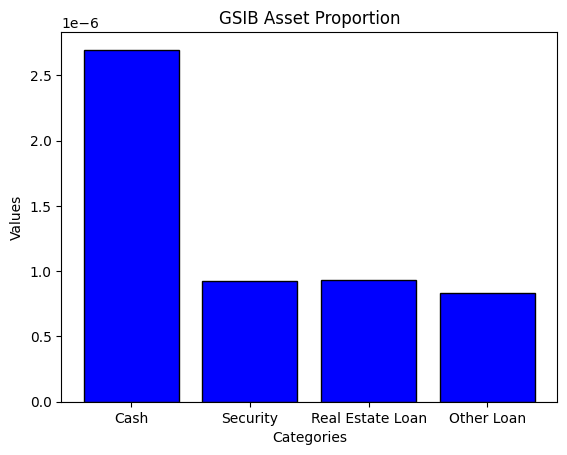

In [92]:
import matplotlib.pyplot as plt

categories = ['Cash', 'Security', 'Real Estate Loan', 'Other Loan']
values = [(GSIB_cash / GSIB_total_asset) * 24,(GSIB_security / GSIB_total_asset) * 24, (GSIB_real_estate_loan / GSIB_total_asset) * 24, (GSIB_other_loan / GSIB_total_asset) * 24]

plt.bar(categories, values, color=['blue' if v >= 0 else 'red' for v in values], edgecolor='black')

plt.title('GSIB Asset Proportion')
plt.xlabel('Categories')
plt.ylabel('Values')

plt.axhline(0, color='grey', linewidth=0.8)

plt.show()

## Liability Table

In [74]:
bank_liability = bank_liability.join(bank_asset[['Bank Category']], how='left')
bank_liability = bank_liability.join(bank_asset[['Total Asset']], how='left')
bank_liability

,Total Liability,Domestic Deposit,Insured Deposit,Uninsured Deposit,Uninsured Time Deposits,Uninsured Long-Term Time Deposits,Uninsured Short-Term Time Deposits,Foreign Deposit,Fed Fund Purchase,Repo,Other Liability,Total Equity,Common Stock,Preferred Stock,Retained Earning,Bank Category,Total Asset
rssd9001,,,,,,,,,,,,,,,,,
37,73591.0,73495.0,0.0,73495.0,1718,683,1035,NaN,0,0.0,96.0,14251.0,1200.0,0.0,11761.0,0,87842.0
242,49360.0,44994.0,0.0,44994.0,4153,529,3624,NaN,0,0.0,16.0,3876.0,120.0,0.0,4947.0,0,53236.0
279,324505.0,295137.0,0.0,295137.0,14346,4874,9473,NaN,0,0.0,2315.0,44370.0,1.0,0.0,32277.0,0,368875.0
354,21004.0,20772.0,0.0,20772.0,261,0,261,NaN,0,0.0,132.0,4073.0,100.0,0.0,698.0,0,25077.0
457,60226.0,52134.0,0.0,52134.0,544,0,544,NaN,0,0.0,92.0,5110.0,60.0,0.0,1188.0,0,65336.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5620869,51982.0,43039.0,4755.0,38284.0,0,0,0,NaN,0,0.0,8943.0,43070.0,50834.0,5980.0,-14779.0,0,95052.0
5650923,45011.0,44905.0,0.0,44905.0,2300,2000,300,NaN,0,0.0,106.0,42141.0,22500.0,0.0,-2369.0,0,87152.0
5660146,1570.0,1570.0,0.0,1570.0,0,0,0,NaN,0,0.0,0.0,33691.0,100.0,0.0,-30.0,0,35261.0


In [75]:
df2 = pd.DataFrame()
df2['Aggregate'] = (bank_liability.sum()/bank_liability['Total Asset'].sum())*100
df2['Full sample(mean)'] = (bank_liability.iloc[:, :-1].div(bank_liability['Total Asset'], axis=0) * 100).apply(lambda x: winsorize(x, limits=[0.05, 0.05])).mean()
df2['Full sample(sd)'] = (bank_liability.iloc[:, :-1].div(bank_liability['Total Asset'], axis=0) * 100).apply(lambda x: winsorize(x, limits=[0.05, 0.05])).std()
df2

,Aggregate,Full sample(mean),Full sample(sd)
Total Liability,90.538426,89.864583,3.170910
Domestic Deposit,76.625774,86.865005,5.248482
Insured Deposit,7.607369,1.214198,2.729040
Uninsured Deposit,69.018404,85.182001,7.409546
Uninsured Time Deposits,1.838361,3.649844,3.008160
Uninsured Long-Term Time Deposits,0.386546,0.848599,0.977959
Uninsured Short-Term Time Deposits,1.287179,2.657451,2.372659
Foreign Deposit,0.000000,NaN,NaN
Fed Fund Purchase,0.052710,0.000000,0.000000
Repo,0.573714,0.291811,0.789751


In [76]:
bank_liability_small = bank_liability[bank_liability["Bank Category"] == 0]
df2['small(mean)'] = (bank_liability_small.iloc[:, :-1].div(bank_liability_small['Total Asset'], axis=0) * 100).apply(lambda x: winsorize(x, limits=[0.05, 0.05])).mean()
df2['small(sd)'] = (bank_liability_small.iloc[:, :-1].div(bank_liability_small['Total Asset'], axis=0) * 100).apply(lambda x: winsorize(x, limits=[0.05, 0.05])).std()
df2

,Aggregate,Full sample(mean),Full sample(sd),small(mean),small(sd)
Total Liability,90.538426,89.864583,3.170910,89.847747,3.290316
Domestic Deposit,76.625774,86.865005,5.248482,87.143782,5.102749
Insured Deposit,7.607369,1.214198,2.729040,0.748612,1.851977
Uninsured Deposit,69.018404,85.182001,7.409546,86.017997,6.500160
Uninsured Time Deposits,1.838361,3.649844,3.008160,3.794753,3.061076
Uninsured Long-Term Time Deposits,0.386546,0.848599,0.977959,0.906746,1.034525
Uninsured Short-Term Time Deposits,1.287179,2.657451,2.372659,2.737420,2.415212
Foreign Deposit,0.000000,NaN,NaN,NaN,NaN
Fed Fund Purchase,0.052710,0.000000,0.000000,0.000000,0.000000
Repo,0.573714,0.291811,0.789751,0.202923,0.610541


In [77]:
bank_liability_large = bank_liability[bank_liability["Bank Category"] == 1]
df2['large(mean)'] = (bank_liability_large.iloc[:, :-1].div(bank_liability_large['Total Asset'], axis=0) * 100).apply(lambda x: winsorize(x, limits=[0.05, 0.05])).mean()
df2['large(sd)'] = (bank_liability_large.iloc[:, :-1].div(bank_liability_large['Total Asset'], axis=0) * 100).apply(lambda x: winsorize(x, limits=[0.05, 0.05])).std()
df2

,Aggregate,Full sample(mean),Full sample(sd),small(mean),small(sd),large(mean),large(sd)
Total Liability,90.538426,89.864583,3.170910,89.847747,3.290316,90.087626,2.287196
Domestic Deposit,76.625774,86.865005,5.248482,87.143782,5.102749,85.754776,5.115755
Insured Deposit,7.607369,1.214198,2.729040,0.748612,1.851977,3.789584,5.817316
Uninsured Deposit,69.018404,85.182001,7.409546,86.017997,6.500160,81.364459,9.979819
Uninsured Time Deposits,1.838361,3.649844,3.008160,3.794753,3.061076,2.861646,2.407564
Uninsured Long-Term Time Deposits,0.386546,0.848599,0.977959,0.906746,1.034525,0.540773,0.538106
Uninsured Short-Term Time Deposits,1.287179,2.657451,2.372659,2.737420,2.415212,2.227352,1.972174
Foreign Deposit,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
Fed Fund Purchase,0.052710,0.000000,0.000000,0.000000,0.000000,0.017317,0.063388
Repo,0.573714,0.291811,0.789751,0.202923,0.610541,0.660218,1.259147


In [78]:
bank_liability_GSIB = bank_liability[bank_liability["Bank Category"] == 2]
df2['GSIB(mean)'] = (bank_liability_GSIB.iloc[:, :-1].div(bank_liability_GSIB['Total Asset'], axis=0) * 100).apply(lambda x: winsorize(x, limits=[0.05, 0.05])).mean()
df2['GSIB(sd)'] = (bank_liability_GSIB.iloc[:, :-1].div(bank_liability_GSIB['Total Asset'], axis=0) * 100).apply(lambda x: winsorize(x, limits=[0.05, 0.05])).std()
df2

,Aggregate,Full sample(mean),Full sample(sd),small(mean),small(sd),large(mean),large(sd),GSIB(mean),GSIB(sd)
Total Liability,90.538426,89.864583,3.170910,89.847747,3.290316,90.087626,2.287196,65.803639,36.873902
Domestic Deposit,76.625774,86.865005,5.248482,87.143782,5.102749,85.754776,5.115755,55.214397,36.640169
Insured Deposit,7.607369,1.214198,2.729040,0.748612,1.851977,3.789584,5.817316,13.774495,19.226991
Uninsured Deposit,69.018404,85.182001,7.409546,86.017997,6.500160,81.364459,9.979819,41.439902,30.018822
Uninsured Time Deposits,1.838361,3.649844,3.008160,3.794753,3.061076,2.861646,2.407564,2.627795,6.937199
Uninsured Long-Term Time Deposits,0.386546,0.848599,0.977959,0.906746,1.034525,0.540773,0.538106,0.268219,0.999734
Uninsured Short-Term Time Deposits,1.287179,2.657451,2.372659,2.737420,2.415212,2.227352,1.972174,1.823919,4.483734
Foreign Deposit,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fed Fund Purchase,0.052710,0.000000,0.000000,0.000000,0.000000,0.017317,0.063388,0.056986,0.257748
Repo,0.573714,0.291811,0.789751,0.202923,0.610541,0.660218,1.259147,0.589871,1.223899


In [79]:
df2 = df2.drop('Total Asset')
df2 = df2.drop('Bank Category')
df2.fillna(0, inplace=True)
df2 = df2.round(1)
df2

,Aggregate,Full sample(mean),Full sample(sd),small(mean),small(sd),large(mean),large(sd),GSIB(mean),GSIB(sd)
Total Liability,90.5,89.9,3.2,89.8,3.3,90.1,2.3,65.8,36.9
Domestic Deposit,76.6,86.9,5.2,87.1,5.1,85.8,5.1,55.2,36.6
Insured Deposit,7.6,1.2,2.7,0.7,1.9,3.8,5.8,13.8,19.2
Uninsured Deposit,69.0,85.2,7.4,86.0,6.5,81.4,10.0,41.4,30.0
Uninsured Time Deposits,1.8,3.6,3.0,3.8,3.1,2.9,2.4,2.6,6.9
Uninsured Long-Term Time Deposits,0.4,0.8,1.0,0.9,1.0,0.5,0.5,0.3,1.0
Uninsured Short-Term Time Deposits,1.3,2.7,2.4,2.7,2.4,2.2,2.0,1.8,4.5
Foreign Deposit,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Fed Fund Purchase,0.1,0.0,0.0,0.0,0.0,0.0,0.1,0.1,0.3
Repo,0.6,0.3,0.8,0.2,0.6,0.7,1.3,0.6,1.2


In [87]:
GSIB_liability = df2.loc['Total Liability','GSIB(mean)']
GSIB_Insured_Deposit = df2.loc['Insured Deposit','GSIB(mean)']
GSIB_Uninsured_Deposit = df2.loc['Uninsured Deposit','GSIB(mean)']
GSIB_Equity = df2.loc['Total Equity','GSIB(mean)']
GSIB_Other_liability = GSIB_liability - GSIB_Insured_Deposit - GSIB_Uninsured_Deposit - GSIB_Equity

proportions_liability_GSIB = {
    'Insured Deposit': (GSIB_Insured_Deposit / GSIB_liability) * 24,
    'Uninsured Deposit': (GSIB_Uninsured_Deposit / GSIB_liability) * 24,
    'Total Equity': (GSIB_Equity / GSIB_liability) * 24,
    'Other': (GSIB_Other_liability / GSIB_liability) * 24
}
proportions_liability_GSIB

{'Insured Deposit': 5.033434650455928,
 'Uninsured Deposit': 15.100303951367781,
 'Total Equity': 12.474164133738604,
 'Other': -8.60790273556231}

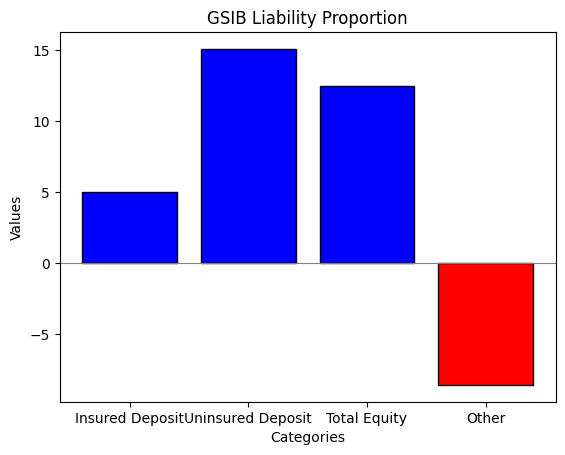

In [90]:
categories = ['Insured Deposit', 'Uninsured Deposit', 'Total Equity', 'Other']
values = [(GSIB_Insured_Deposit / GSIB_liability) * 24,(GSIB_Uninsured_Deposit / GSIB_liability) * 24, (GSIB_Equity / GSIB_liability) * 24, (GSIB_Other_liability / GSIB_liability) * 24]

plt.bar(categories, values, color=['blue' if v >= 0 else 'red' for v in values], edgecolor='black')

plt.title('GSIB Liability Proportion')
plt.xlabel('Categories')
plt.ylabel('Values')

plt.axhline(0, color='grey', linewidth=0.8)

plt.show()

## Figure A1
### Total Asset Plot

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

In [21]:
aggregate_sum_assets = bank_asset['Total Asset'].sum()
aggregate_cash = bank_asset['cash'].sum()
aggregate_security = bank_asset['security_total'].sum()
aggregate_real_estate_loan = bank_asset['Real_Estate_Loan'].sum()
aggregate_Comm_Indu_Loan = bank_asset['Comm_Indu_Loan'].sum()
aggregate_Consumer_Loan = bank_asset['Consumer_Loan'].sum()
aggregate_Agri_Loan = bank_asset['Agri_Loan'].sum()
aggregate_other_loan = aggregate_Comm_Indu_Loan + aggregate_Consumer_Loan + aggregate_Agri_Loan
aggregate_other_asset = aggregate_sum_assets - aggregate_cash - aggregate_security - aggregate_real_estate_loan - aggregate_other_loan
proportions = {
    'Cash': (aggregate_cash / aggregate_sum_assets) * 24,
    'Security': (aggregate_security / aggregate_sum_assets) * 24,
    'Real Estate Loan': (aggregate_real_estate_loan / aggregate_sum_assets) * 24,
    'Other Loan': (aggregate_other_loan / aggregate_sum_assets) * 24,
    'Other Asset': (aggregate_other_asset / aggregate_sum_assets) * 24
}
proportions

{'Cash': 3.384761873186202,
 'Security': 6.109962425053711,
 'Real Estate Loan': 5.411820656517145,
 'Other Loan': 4.823931263748993,
 'Other Asset': 4.269523781493949}

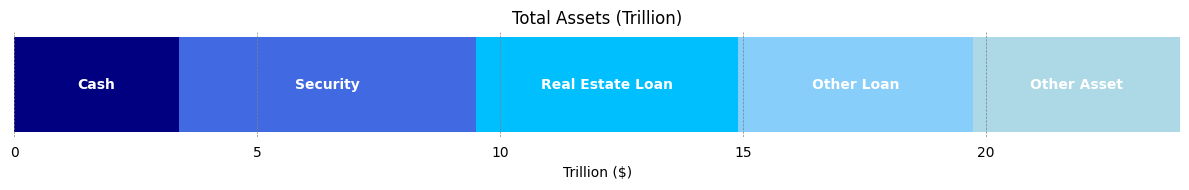

In [22]:
colors_assets = ['navy', 'royalblue', 'deepskyblue', 'lightskyblue', 'lightblue']

fig, ax = plt.subplots(figsize=(12, 2))  

starting = 0

for (category, value), color in zip(proportions.items(), colors_assets):
    ax.barh('Total Assets', value, left=starting, color=color)
    text_x = starting + value / 2  
    ax.text(text_x, 0, category, ha='center', va='center', color='white', fontsize=10, fontweight='bold')
    starting += value

ax.set_xlim(0, 24)
ax.set_xlabel('Trillion ($)')

ax.get_yaxis().set_visible(False)

ax.set_title('Total Assets (Trillion)')

# Remove all spines
for spine in ax.spines.values():
    spine.set_visible(False)

# Remove ticks
ax.tick_params(bottom=False, left=False)

# Show the grid for the x-axis only
ax.xaxis.grid(True, color='grey', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()


### Total Liability Plot

In [23]:
aggregate_liability = bank_liability['Total Liability'].sum()
aggregate_Insured_Deposit = bank_liability['Insured Deposit'].sum()
aggregate_Uninsured_Deposit = bank_liability['Uninsured Deposit'].sum()
aggregate_Equity = bank_liability['Total Equity'].sum()
aggregate_Other_liability = aggregate_liability - aggregate_Insured_Deposit - aggregate_Uninsured_Deposit - aggregate_Equity

proportions_liability = {
    'Insured Deposit': (aggregate_Insured_Deposit / aggregate_liability) * 24,
    'Uninsured Deposit': (aggregate_Uninsured_Deposit / aggregate_liability) * 24,
    'Total Equity': (aggregate_Equity / aggregate_liability) * 24,
    'Other': (aggregate_Other_liability / aggregate_liability) * 24
}
proportions_liability

{'Insured Deposit': 2.0165676687457816,
 'Uninsured Deposit': 18.29545498434364,
 'Total Equity': 2.5085155103512173,
 'Other': 1.1794618365593625}

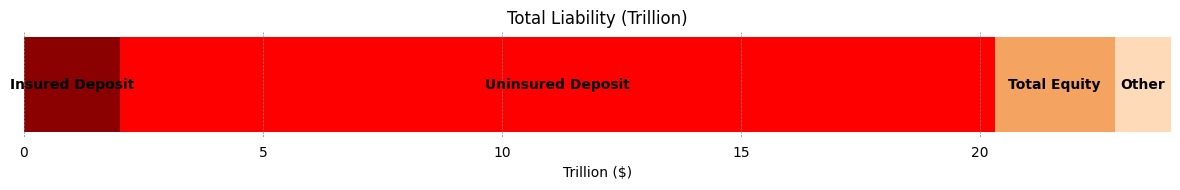

In [51]:
colors_liabilities = ['darkred', 'red', 'sandybrown', 'peachpuff']

fig, ax = plt.subplots(figsize=(12, 2))  # Similar size to the assets chart for consistency

starting_liability = 0

for (category, value), color in zip(proportions_liability.items(), colors_liabilities):
    ax.barh('Total Liability', value, left=starting_liability, color=color)
    # Annotate the segment with the category name
    text_x = starting_liability + value / 2  # Position the text in the middle of the segment
    ax.text(text_x, 0, category, ha='center', va='center', color='black', fontsize=10, fontweight='bold')
    starting_liability += value

ax.set_xlim(0, 24)
ax.set_xlabel('Trillion ($)')

ax.get_yaxis().set_visible(False)

ax.set_title('Total Liability (Trillion)')

for spine in ax.spines.values():
    spine.set_visible(False)

ax.tick_params(bottom=False, left=False)

ax.xaxis.grid(True, color='grey', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()
